In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time,math,csv
import itertools
import collections

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from IPython.display import display

# geo
import fiona
import shapely.geometry
from rtree import index

#simple-maps
sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

## Load housing units per block group

In [2]:
county_id_list = []
bg_id_list = []
bg_housing_unit_estimates = []

f = open("data/regression_estimated_housing_units.csv", "r")
predicted_years = list(map(int, f.readline().strip().split(",")[2:]))
num_block_groups = 0
num_years = len(predicted_years)

for line in f:
    line = line.strip()
    if line != "":
        parts = line.split(",")
        county_id = parts[0]
        bg_id = parts[1]
        values = list(map(float,parts[2:]))
        
        county_id_list.append(county_id)
        bg_id_list.append(bg_id)
        bg_housing_unit_estimates.append(values)
        
        num_block_groups += 1
        assert len(values) == num_years
f.close()

bg_housing_unit_estimates = np.array(bg_housing_unit_estimates)
assert bg_housing_unit_estimates.shape[0] == num_block_groups
assert bg_housing_unit_estimates.shape[1] == num_years

## Load block group areas

In [3]:
bg_area = {}

f = fiona.open("data/boundary_shapefiles/block_groups_2012/tl_2012_all_bg.shp", "r")
for s in f:
    bg_id = s["properties"]["GEOID"]
    state_id = s["properties"]["STATEFP"]
    land_area = int(s["properties"]["ALAND"])
    
    bg_area[bg_id] = land_area
f.close()

In [4]:
f = open("data/block_group_land_areas.csv", "w")
f.write("Geo_COUNTY_FIPS,Geo_BG_FIPS,ALAND\n")
for i in range(num_block_groups):
    f.write("%s,%s,%d\n" % (county_id_list[i], bg_id_list[i], bg_area[bg_id_list[i]]))
f.close()

## Calculate housing unit density

In [5]:
bg_area_vector = []
for bg_id in bg_id_list:
    bg_area_vector.append(bg_area[bg_id] / 1000.0)
bg_area_vector = np.array(bg_area_vector, dtype=float)
bg_area_vector = bg_area_vector.reshape(-1,1)

In [6]:
bg_area_vector.shape

(216330, 1)

In [7]:
bg_hu_density = bg_housing_unit_estimates / bg_area_vector

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [8]:
argsorted_bg_hu_density = np.argsort(bg_hu_density, axis=0, kind="mergesort")

In [14]:
argsorted_bg_hu_density[-532-number_to_show:-532,-1]

array([131718, 126738, 137932, 200905, 134743, 135134, 134116, 134981,
       134917, 134919, 130096, 131292,  93171, 135066, 126852, 134714,
        39884, 135005, 134354, 134954,  58883,  14612, 137014, 134072,
       134050, 134554, 126828,  27779, 136822, 137077,  58629, 134662,
       134698,  87562,  14728, 134495, 136926, 126607, 137765,  45731,
       134721, 131375, 134892, 134701, 200641, 134224,  45741, 127036,
       136576,  45747, 131271,  14638, 134943, 134134, 134298, 127434,
       134327, 134141, 136959, 134174,  93193, 199940, 130853,  58798,
       136839, 138420,  88611, 134113, 130899,  58838, 136919, 134821,
       134532,  93213, 131210, 134156, 134373,  14712, 134661, 134709,
       137723,  41000, 134129,  27646, 131515, 134677, 126887, 135160,
       135150,  46093, 134351,  58831,  14642,  93212,  14717,  39886,
       134730, 127368, 134504, 126964, 137877, 131291,  46215,  45719,
        14737, 130781,  45716, 127044, 134789, 131392, 134117, 135048,
      

In [15]:
number_to_show = 10000
highlighted_counties = {
    bg_id_list[i]: 1 if i in argsorted_bg_hu_density[-532-number_to_show:-532,0] else 0
    for i in range(num_block_groups)
}

f = open("data/block_group_top1000_hu_density.csv", "w")
f.write("Geo_COUNTY_FIPS,Geo_BG_FIPS,HIGHLIGHT\n")
for i in range(num_block_groups):
    f.write("%s,%s,%d\n" % (county_id_list[i], bg_id_list[i], highlighted_counties[bg_id_list[i]]))
f.close()

f = open("data/block_group_top1000_hu_density.csvt","w")
f.write('"String","String","Integer"')
f.close()

In [10]:
mask = ~np.isnan(bg_hu_density[:,0])

In [11]:
for i in range(bg_hu_density.shape[1]):
    assert np.all(mask == ~np.isnan(bg_hu_density[:,i]))

In [12]:
bg_hu_density = bg_hu_density[mask, :]

In [13]:
sorted_bg_hu_density = np.sort(bg_hu_density, axis=0, kind="mergesort")

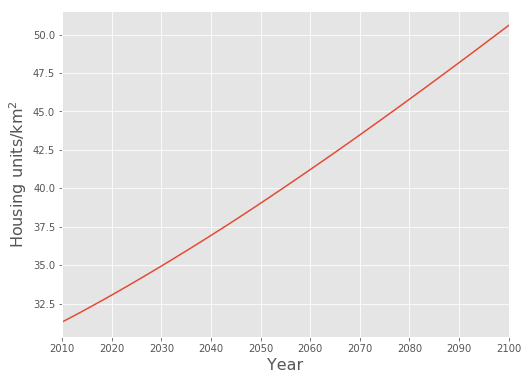

In [14]:
plt.figure(figsize=(8,6))

xs = np.arange(2010,2101)
ys = np.mean(sorted_bg_hu_density[-1000:,:], axis=0)

plt.plot(xs, ys)

plt.xlim([2010, 2100])

plt.xlabel("Year", fontsize=16)
plt.ylabel("Housing units/km$^2$", fontsize=16)

plt.show()
plt.close()